In [1]:
import pickle
from collections import OrderedDict
import scipy.stats
from pylab import * 
import seaborn as sns
%matplotlib inline

In [2]:
NMER = 5

In [3]:
args = {
    "true_events": "/home/ibis/gregor.sturm/nanopore/own/notebooks/03_pipeline/david_alignment_true_events.pickle",
    "ref": "/home/ibis/gregor.sturm/nanopore/david_eccles_bc_ideas/mouse_ref.fa",
}

In [4]:
true_events = pickle.load(open(args["true_events"], 'rb'))

In [5]:
ref_file = args["ref"]
test = !cat {ref_file} | grep ">"
print(test)
ref = !cat {ref_file} | grep -v ">"
ref = ref[0]
print(ref[:100])

['>mmusMT_PCR1']
GTTAATGTAGCTTAATAACAAAGCAAAGCACTGAAAATGCTTAGATGGATAATTGTATCCCATAAACACAAAGGTTTGGTCCTGGCCTTATAATTAATTA


### make dict with all kmers 

In [7]:
from itertools import product

all_5mers = [''.join(i) for i in product("ACGT",repeat=NMER)]
ev_map = OrderedDict((k,[]) for k in all_5mers)

In [8]:
for ev in true_events: 
    ev_map[ev["kmer"][:NMER]].append(ev)

# Analysis

### compare with distributions in sequence

* kmer-frequence
* length (how many kmers were mapped correctly, at all) 

In [9]:
kmer_freq = OrderedDict((k, 0) for k in all_5mers)
for i in range(0, len(ref)-(NMER-1)):
    kmer_freq[ref[i:i+NMER]] += 1

In [10]:
true_kmer_freq = OrderedDict((k, len(v)) for k, v in ev_map.items())

In [11]:
scipy.stats.pearsonr(list(true_kmer_freq.values()), list(kmer_freq.values()))

(0.89018229238682323, 0.0)

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


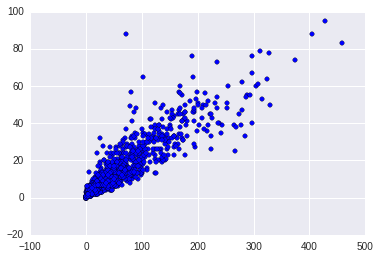

In [12]:
fig, ax = subplots()
ax.scatter(list(true_kmer_freq.values()), list(kmer_freq.values()))
fig.show()

#### outliers = kmers that are difficult to predict

### => Result

* there is a pretty strong correlation (pearson r = .9) between the frequency of kmers in the reference and the frequency of correctly predicted kmers
    * however there are some outliers
   

## compare features

In [13]:
def sorted_boxplot(ordered_dict):
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 1})
    map2 = OrderedDict(sorted(ordered_dict.items(), key=lambda x : 0 if len(x[1]) == 0 else np.mean(x[1])))
    fig, ax = subplots(figsize = (15, 5))
    boxplot(list(map2.values()))
    ax.set_xticklabels(list(map2.keys()), rotation=90, fontsize=8)
    fig.show()

### mean pA

In [17]:
pa_map = {}
for kmer, events in ev_map.items():
    kmer_means = []
    for ev in events: 
#         l, r = ev["template.start"], ev["template.end"]
#         ch = ev["channel"]
#         kmer_means.append(np.mean(all_raw[ch][l:r]))
        mean_templ = ev["template.mean"]
        mean_compl = ev["complement.mean"]
        if not np.isnan(mean_templ):
            kmer_means.append(mean_templ)
        if not np.isnan(mean_compl):
            kmer_means.append(mean_compl)
    pa_map[kmer] = kmer_means

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


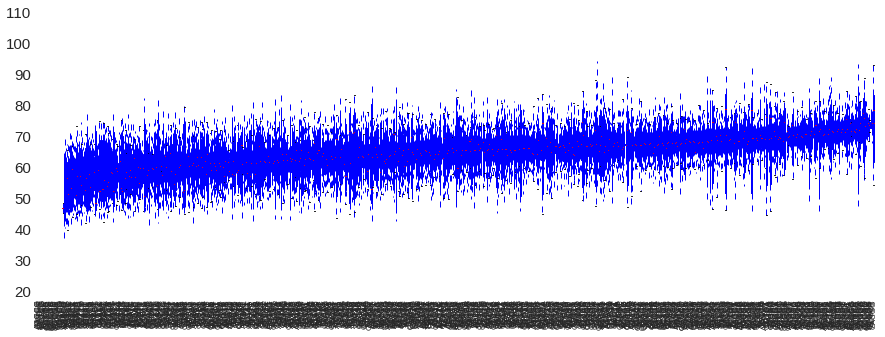

In [18]:
sorted_boxplot(pa_map)

### mean stdev

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


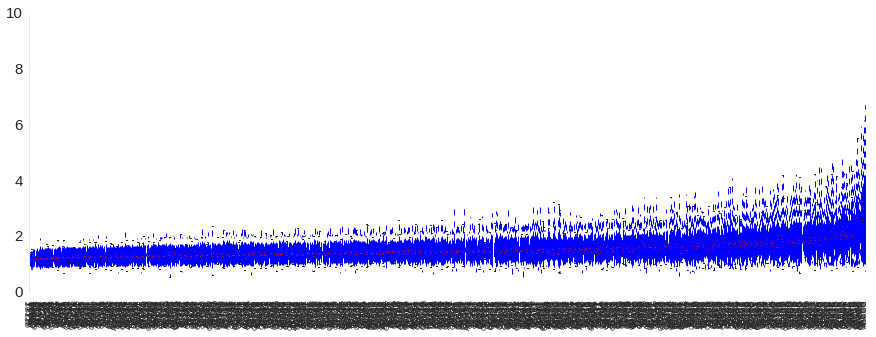

In [25]:
stdev_map = {}
for kmer, events in ev_map.items():
    kmer_std = []
    for ev in events: 
#         l, r = ev["start"], ev["end"]
#         ch = ev["channel"]
#         kmer_std.append(np.std(all_raw[ch][l:r]))
        std_templ = ev["template.stdv"]
        std_compl = ev["complement.stdv"]
        if not np.isnan(std_templ):
            kmer_std.append(std_templ)
        if not np.isnan(std_compl):
            kmer_std.append(std_compl)
        stdev_map[kmer] = kmer_std
sorted_boxplot(stdev_map)

### mean length

/home/ibis/gregor.sturm/bin/anaconda3/lib/python3.4/site-packages/matplotlib/figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


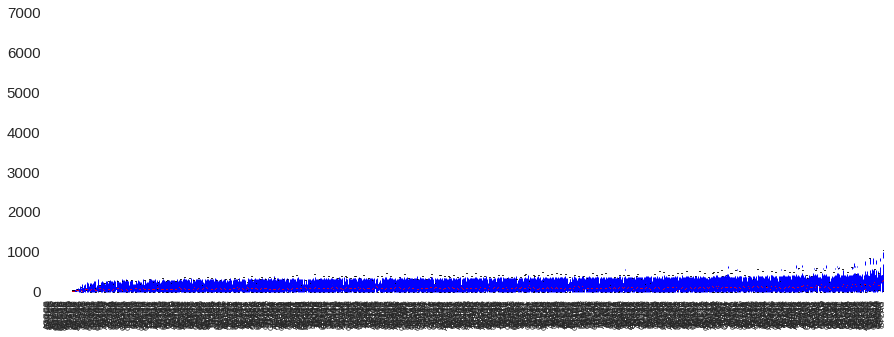

In [28]:
len_map = {}
for kmer, events in ev_map.items():
    kmer_len = []
    for ev in events: 
        for t in ["template", "complement"]:
            l, r = ev["{0}.start".format(t)], ev["{0}.end".format(t)]
            length = r-l
            if not np.isnan(length):
                kmer_len.append(length)
    len_map[kmer] = kmer_len
sorted_boxplot(len_map)